In [1]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MultiOmicsIntegration/comp-401


In [2]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import json
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [3]:
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks


# Subtyping (RNA, CNV, RPPA)

In [ ]:
datasets = {
            'rna': '../data/kipan/RNASeq.csv',
            'cnv': '../data/kipan/CNV.csv',
            'rppa': '../data/kipan/RPPA.csv',
}

labels = '../data/kipan/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

NameError: name 'pd' is not defined

## Preprocessing

### Removing low-variance + null features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [ ]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.10)
    print(modality, new_data[modality].shape)

In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

In [ ]:
subtypes['histological_type'].value_counts()

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

## Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [ ]:
kipan_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_scoring)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(estimator_names, base_scores['cnv'], 'RNA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [ ]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method

    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])

        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)

        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking

        return model

    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_

        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

In [ ]:
modality_metrics

In [ ]:
modality_metrics

In [ ]:
modality_metrics

In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_results.json", "w") as outfile:
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_base_learner_modality_results.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Scoring

In [ ]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

In [ ]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_bar_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

NameError: name 'plot_box_scores' is not defined

## Multi Omics Integration Ensemble

### Cross Val Predict

In [ ]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method ='predict_proba')

NameError: name 'StratifiedKFold' is not defined

In [ ]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'cnv': preds['cnv'].argmax(axis=1),
    'rppa': preds['rppa'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_KICH', 'rna_KIRC', 'rna_KIRP']), pd.DataFrame(preds['cnv'], columns=['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']), pd.DataFrame(preds['rppa'], columns=['rppa_KICH', 'rppa_KIRC', 'rppa_KIRP'])], axis=1)

In [ ]:
preds_class_df

In [ ]:
preds_proba_df

With Voting:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Find the majority class for each sample
majority_class = pred_df.mode(axis=1)[0]

# Calculate the scores
accuracy = accuracy_score(y, majority_class)
f1 = f1_score(y, majority_class, average='weighted')
recall = recall_score(y, majority_class, average=None)

scores_df = pd.DataFrame({'accuracy': [accuracy], 'f1': [f1], 'recall (KICH)': [recall[0]], 'recall (KIRC)': [recall[1]], 'recall (KIRP)': [recall[2]]})

# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, scores_df.rename(index={0: 'majority_class'})])

integration_voting_metrics


NameError: name 'pred_df' is not defined

With Stacking:

In [ ]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

In [ ]:
integration_metrics

In [ ]:
names = ['cnv', 'rna', 'rppa', 'integration']
integration = []
integration.append(scores['cnv'])
integration.append(scores['rna'])
integration.append(scores['rppa'])
integration.append(integration_scores)

In [ ]:
plot_scores(names, integration)

In [ ]:
rna_cnv_rppa_scores, rna_cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
cnv_rppa_scores, cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_rppa_scores, rna_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='rna + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_cnv_scores, rna_cnv_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']], y, name='rna + cnv', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

In [ ]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_cnv_rppa_df, cnv_rppa_df, rna_rppa_df, rna_cnv_df])

In [ ]:
integration_stacking_metrics

In [ ]:
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']
integration = []
integration.append(scores['rna'])
integration.append(scores['cnv'])
integration.append(scores['rppa'])
integration.append(rna_cnv_rppa_scores)
integration.append(cnv_rppa_scores)
integration.append(rna_rppa_scores)
integration.append(rna_cnv_scores)

In [ ]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

### Ensemble Model as a Custom Classifier

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})


In [ ]:
integration_metrics['rna + cnv + rppa']

In [ ]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_multi_omics_results.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_multi_omics_results.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
all_integration_metrics

In [ ]:
plot_bar_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['cnv + rppa'], ensemble_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})
ensemble_results['rppa'], ensemble_metrics['rppa'] = get_cross_metrics(classifiers['rppa'], X['rppa'], y, name='rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)


In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('cnv + rppa', 'rppa'),
    ('rna + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

In [ ]:
plot_box_scores(['cnv + rppa', 'rppa'], [ensemble_results['cnv + rppa'], ensemble_results['rppa']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_5x3_results.json", "w") as outfile:
    json.dump(ensemble_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X['cnv'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
classifiers['cnv'].fit(X_train, y_train)

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_scoring.items():
  #y_preds = meta_ensembles['rna + rppa'].predict(X_test)
  baseline_scores[name] = get_scorer(scorer)(classifiers['cnv'], X_test, y_test)

In [ ]:
print(baseline_scores)

In [ ]:
r = permutation_importance(classifiers['cnv'], X_test, y_test, n_repeats=2, random_state=0, scoring=kipan_scoring, n_jobs=-1)

In [ ]:
X['cnv']

In [ ]:
for i in r['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if r['balanced_accuracy'].importances_mean[i] - 2 * r['balanced_accuracy'].importances_std[i] > 0:
         print(f"{X['rppa'].columns[i]:<8}"
               f"{r['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {r['balanced_accuracy'].importances_std[i]:.3f}")

In [ ]:
r['balanced_accuracy'].importances_mean.argsort()[::-1]

In [ ]:
r['balanced_accuracy'].importances_mean

In [ ]:
print("Top 20 features")

for i in r['balanced_accuracy'].importances_mean.argsort()[:20]:
  if r['balanced_accuracy'].importances_mean[i] - 2 * r['balanced_accuracy'].importances_std[i] < 0:
     print(f"{X['cnv'].columns[i]:<8}: "
               f"{r['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {r['balanced_accuracy'].importances_std[i]:.3f}")


# Subtyping (RNA, CNV, RPPA) - Feature Selection

In [4]:
datasets = {
            'rna': '../data/kipan/subtyping/RNASeq.csv',
            'cnv': '../data/kipan/subtyping/CNV.csv',
            'rppa': '../data/kipan/subtyping/RPPA.csv',
}

labels = '../data/kipan/subtyping/Clinical.csv'

In [5]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (736, 20190)
cnv (736, 24776)
rppa (736, 202)


## Preprocessing

### Removing low-variance + null features

In [6]:
!pip3 install scanpy

In [7]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [8]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [9]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [10]:
sc.pp.highly_variable_genes(adata['cnv'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [11]:
sc.pp.highly_variable_genes(adata['rppa'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


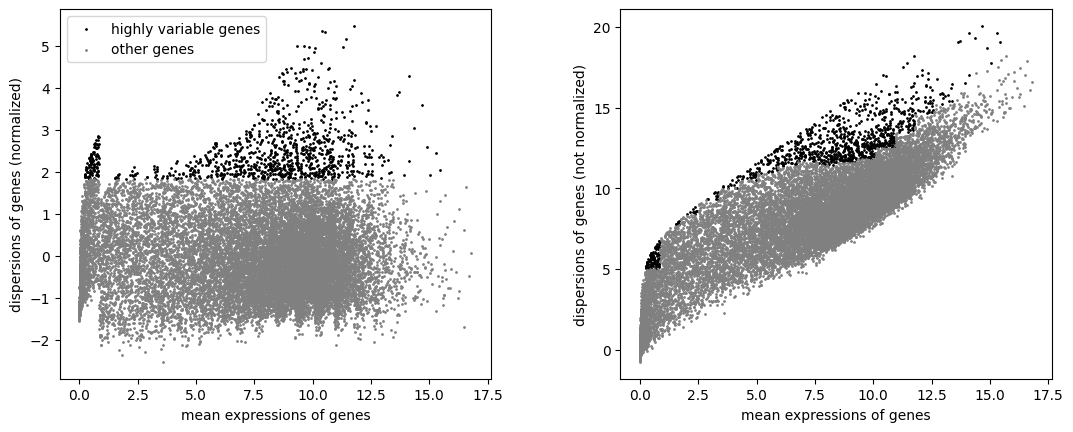

In [12]:
sc.pl.highly_variable_genes(adata['rna'])

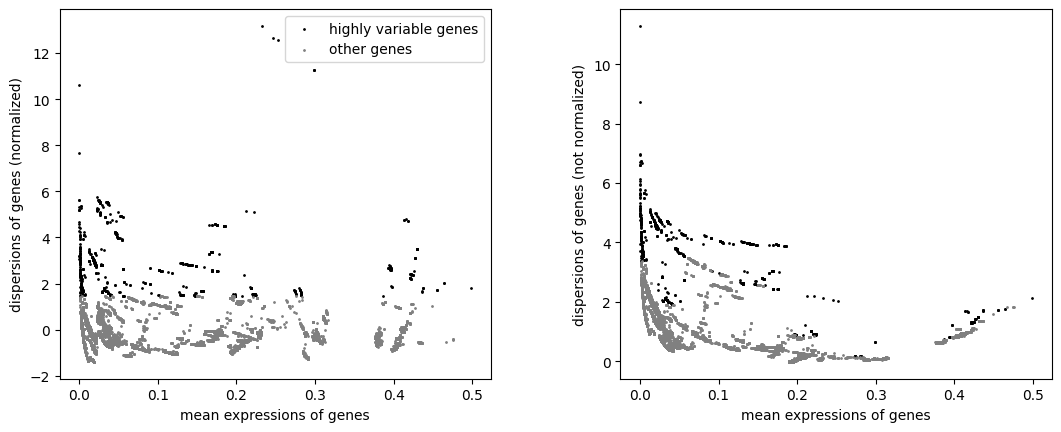

In [13]:
sc.pl.highly_variable_genes(adata['cnv'])

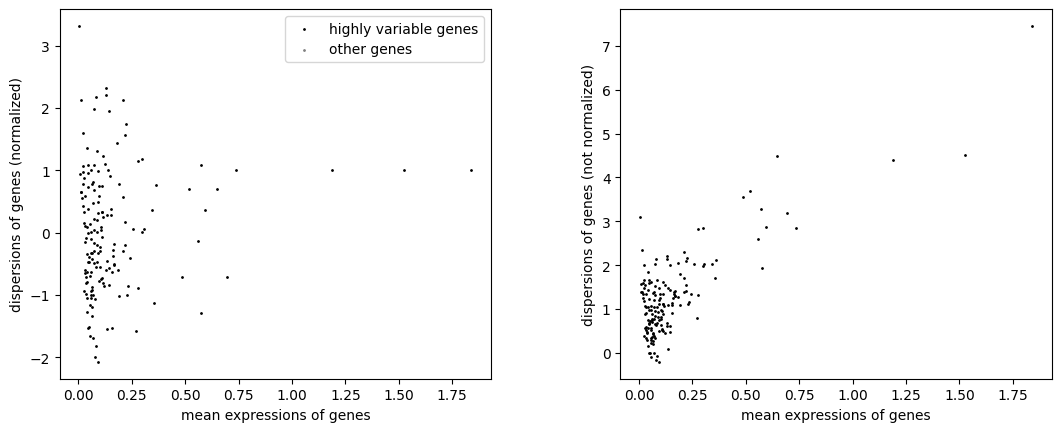

In [14]:
sc.pl.highly_variable_genes(adata['rppa'])

In [15]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 736 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'cnv': AnnData object with n_obs × n_vars = 736 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'rppa': AnnData object with n_obs × n_vars = 736 × 168
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [17]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (736, 1000)
cnv (736, 1000)
rppa (736, 168)


In [18]:
subtypes['histological_type'].value_counts()

histological_type
kidneyclearcellrenalcarcinoma        467
kidneypapillaryrenalcellcarcinoma    206
kidneychromophobe                     63
Name: count, dtype: int64

In [19]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

array(['kidneychromophobe', 'kidneyclearcellrenalcarcinoma',
       'kidneypapillaryrenalcellcarcinoma'], dtype=object)

## Base Learners

In [20]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [21]:
kipan_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_scoring)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.951 +/- 0.021,0.949 +/- 0.025,0.951 +/- 0.020,0.938 +/- 0.090,0.951 +/- 0.031,0.956 +/- 0.024
balanced_random_forest,0.952 +/- 0.010,0.959 +/- 0.017,0.953 +/- 0.009,0.969 +/- 0.062,0.946 +/- 0.021,0.961 +/- 0.020
deep_nn,0.948 +/- 0.017,0.947 +/- 0.023,0.949 +/- 0.017,0.938 +/- 0.090,0.947 +/- 0.029,0.956 +/- 0.024
svc,0.952 +/- 0.020,0.949 +/- 0.027,0.953 +/- 0.019,0.938 +/- 0.090,0.953 +/- 0.028,0.956 +/- 0.024


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.024,0.796 +/- 0.041,0.860 +/- 0.025,0.685 +/- 0.126,0.923 +/- 0.028,0.781 +/- 0.073
balanced_random_forest,0.867 +/- 0.014,0.862 +/- 0.032,0.869 +/- 0.013,0.873 +/- 0.105,0.882 +/- 0.033,0.830 +/- 0.060
deep_nn,0.827 +/- 0.007,0.766 +/- 0.031,0.824 +/- 0.009,0.700 +/- 0.085,0.904 +/- 0.034,0.694 +/- 0.080
svc,0.731 +/- 0.058,0.759 +/- 0.047,0.738 +/- 0.056,0.794 +/- 0.109,0.698 +/- 0.073,0.786 +/- 0.081


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.872 +/- 0.023,0.812 +/- 0.065,0.871 +/- 0.024,0.705 +/- 0.182,0.925 +/- 0.030,0.805 +/- 0.050
balanced_random_forest,0.966 +/- 0.015,0.955 +/- 0.033,0.966 +/- 0.016,0.953 +/- 0.062,0.985 +/- 0.009,0.927 +/- 0.055
deep_nn,0.967 +/- 0.017,0.936 +/- 0.034,0.967 +/- 0.017,0.876 +/- 0.078,0.991 +/- 0.011,0.942 +/- 0.036
svc,0.851 +/- 0.018,0.824 +/- 0.042,0.853 +/- 0.018,0.796 +/- 0.123,0.884 +/- 0.034,0.791 +/- 0.026


(None, None, None)

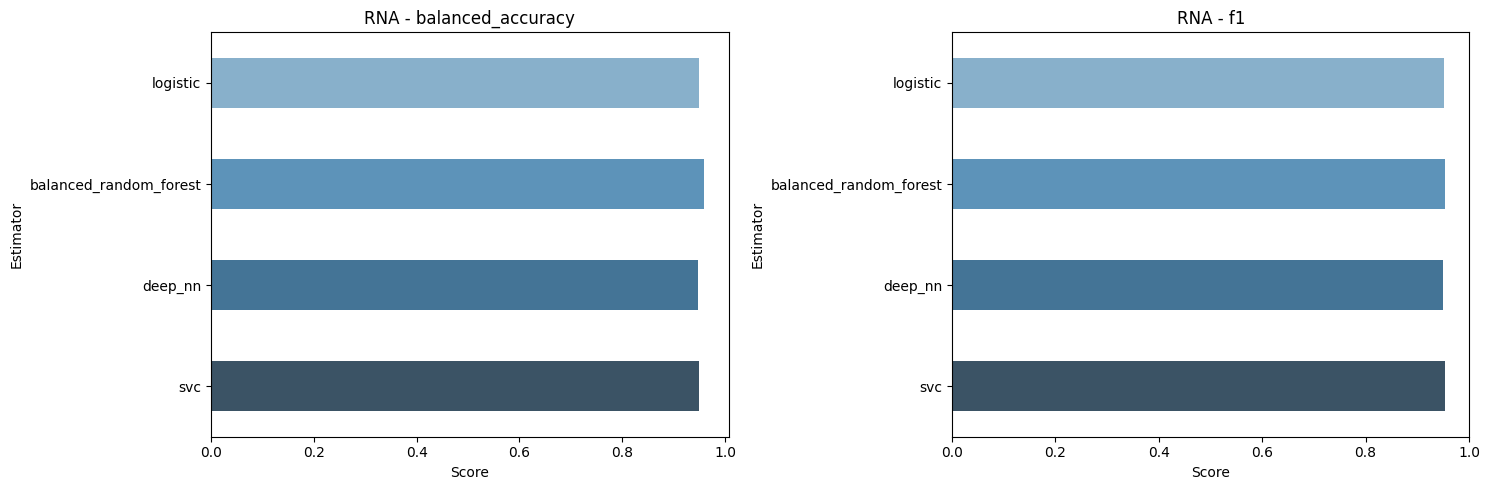

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

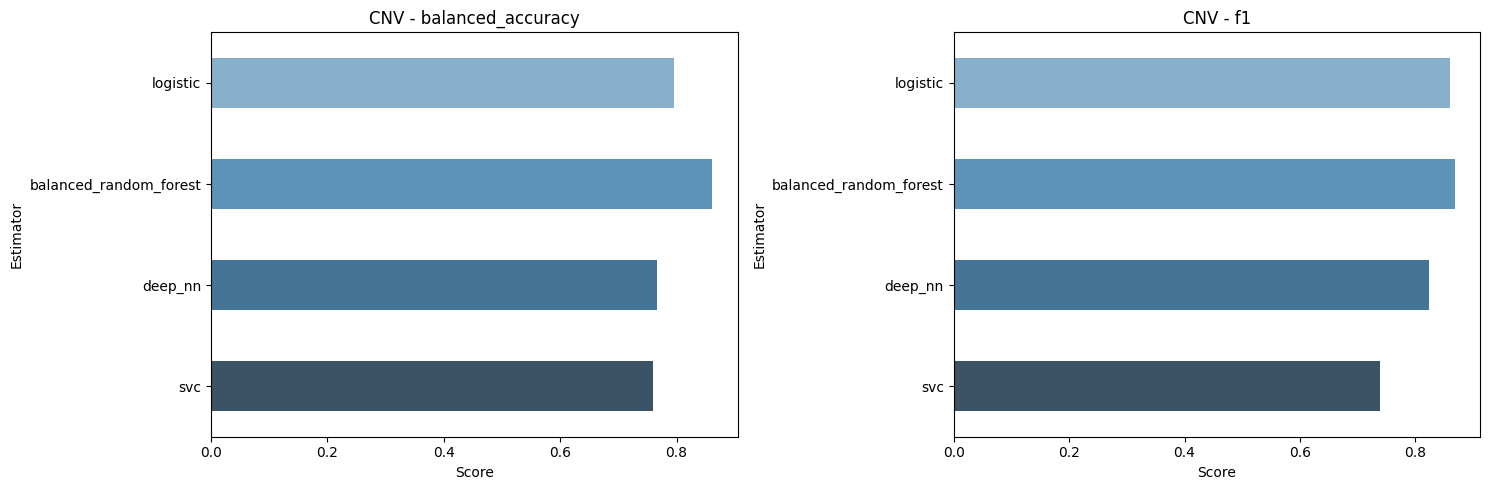

In [ ]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

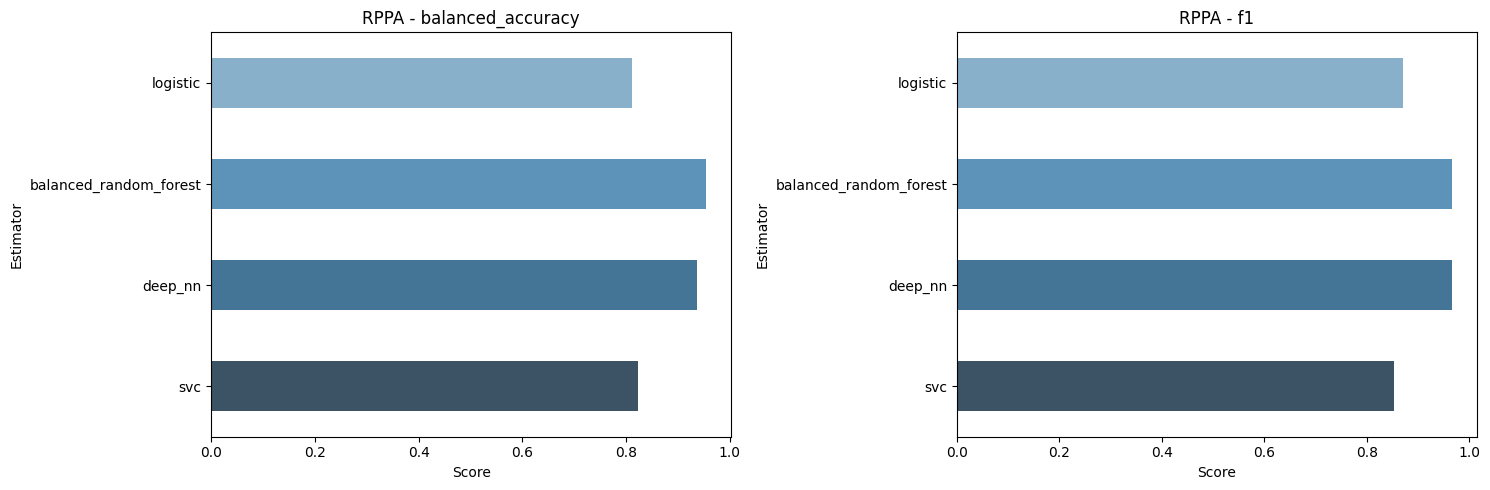

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


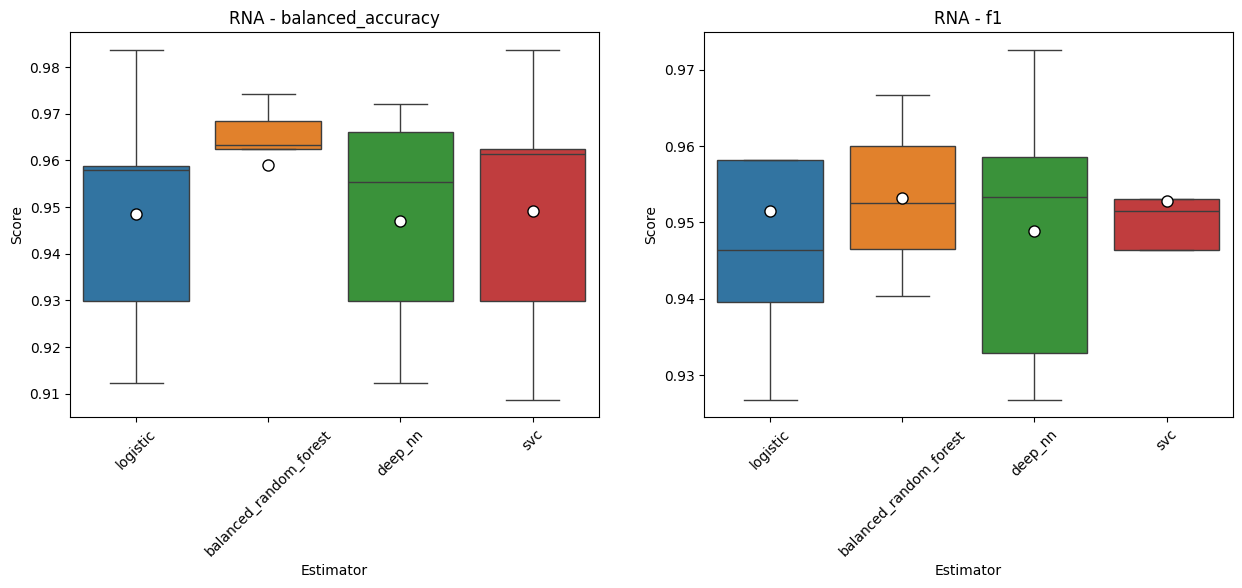

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


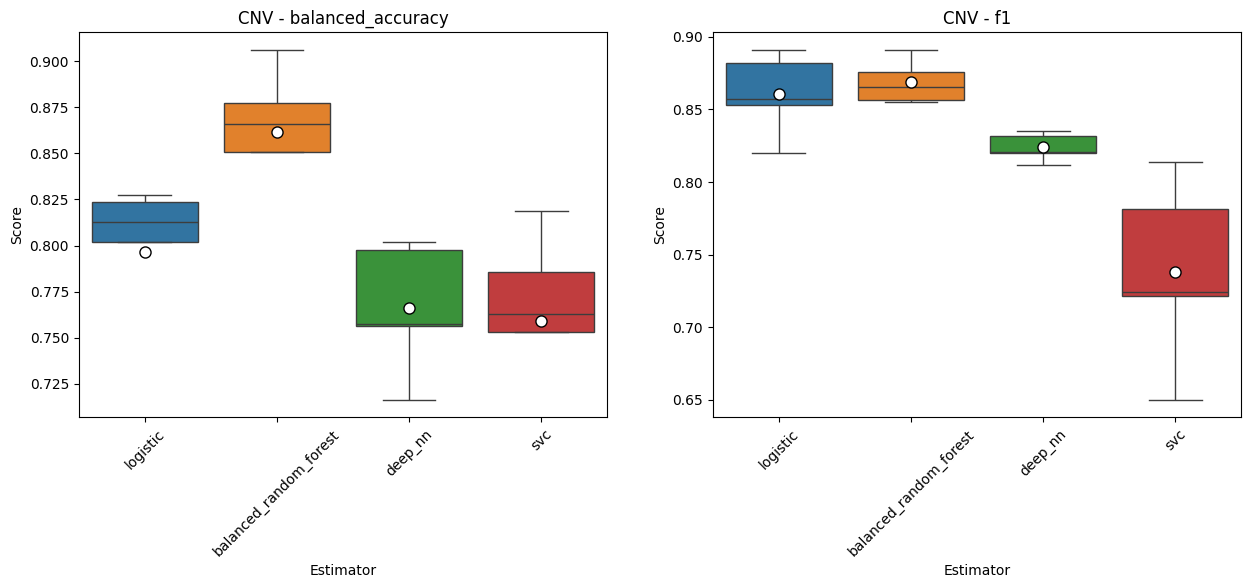

In [ ]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


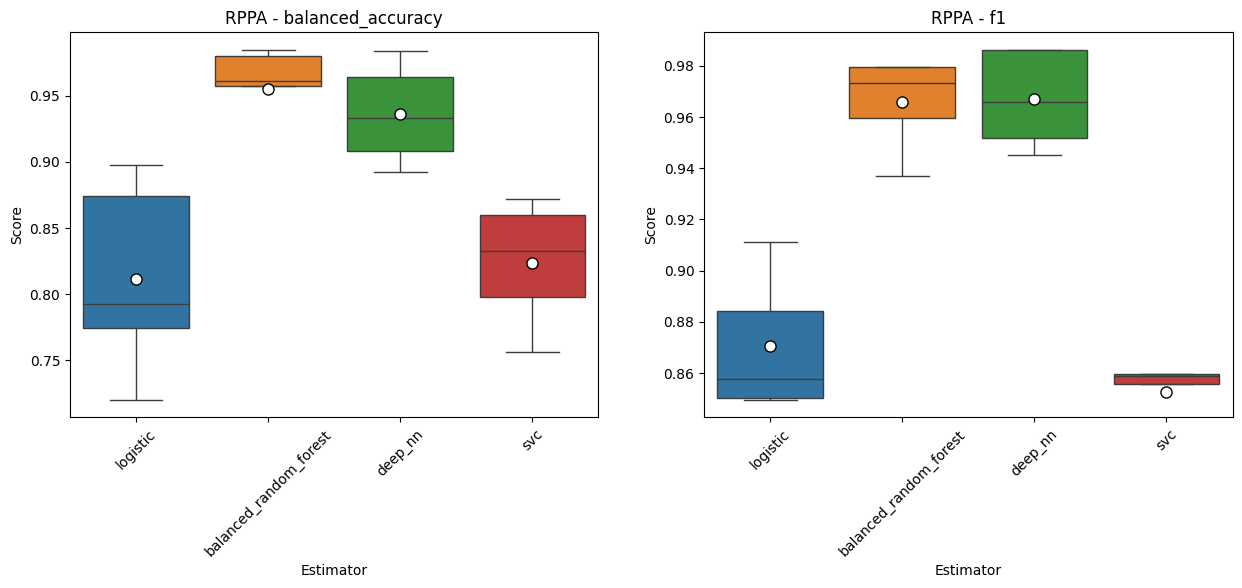

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

In [22]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_scoring, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1))

 25%|██▌       | 1/4 [00:26<01:20, 26.83s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.957 +/- 0.021   0.952 +/- 0.027  0.957 +/- 0.021  0.937 +/- 0.058   

            recall (KIRC)    recall (KIRP)  
logistic  0.959 +/- 0.023  0.958 +/- 0.033  


 50%|█████     | 2/4 [00:44<00:42, 21.31s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.952 +/- 0.021   0.958 +/- 0.023  0.952 +/- 0.021   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.969 +/- 0.047  0.946 +/- 0.023  0.960 +/- 0.033  


 75%|███████▌  | 3/4 [01:02<00:20, 20.12s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.954 +/- 0.017   0.955 +/- 0.024  0.955 +/- 0.017  0.947 +/- 0.054   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.950 +/- 0.019  0.966 +/- 0.031  


100%|██████████| 4/4 [01:04<00:00, 16.08s/it]


svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.957 +/- 0.018   0.954 +/- 0.023  0.958 +/- 0.017  0.942 +/- 0.060   

       recall (KIRC)    recall (KIRP)  
svc  0.958 +/- 0.021  0.961 +/- 0.033  


 25%|██▌       | 1/4 [00:18<00:56, 18.79s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.863 +/- 0.025   0.791 +/- 0.046  0.861 +/- 0.025  0.668 +/- 0.145   

            recall (KIRC)    recall (KIRP)  
logistic  0.927 +/- 0.021  0.780 +/- 0.052  


 50%|█████     | 2/4 [00:30<00:29, 14.75s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.856 +/- 0.031   0.847 +/- 0.041  0.857 +/- 0.030   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.863 +/- 0.097  0.881 +/- 0.042  0.798 +/- 0.070  


 75%|███████▌  | 3/4 [01:31<00:35, 35.71s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.837 +/- 0.021   0.761 +/- 0.041  0.833 +/- 0.022  0.650 +/- 0.118   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.916 +/- 0.024  0.715 +/- 0.046  


100%|██████████| 4/4 [01:33<00:00, 23.32s/it]


svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.699 +/- 0.070   0.686 +/- 0.093  0.708 +/- 0.067  0.602 +/- 0.207   

       recall (KIRC)    recall (KIRP)  
svc  0.676 +/- 0.086  0.781 +/- 0.093  


 25%|██▌       | 1/4 [00:01<00:03,  1.22s/it]

logistic                  accuracy balanced_accuracy               f1    recall (KICH)  \
logistic  0.873 +/- 0.033   0.805 +/- 0.047  0.872 +/- 0.033  0.674 +/- 0.111   

            recall (KIRC)    recall (KIRP)  
logistic  0.927 +/- 0.030  0.813 +/- 0.067  


 50%|█████     | 2/4 [00:11<00:12,  6.32s/it]

balanced_random_forest                                accuracy balanced_accuracy               f1  \
balanced_random_forest  0.963 +/- 0.021   0.957 +/- 0.036  0.963 +/- 0.021   

                          recall (KICH)    recall (KIRC)    recall (KIRP)  
balanced_random_forest  0.958 +/- 0.085  0.975 +/- 0.019  0.937 +/- 0.040  


 75%|███████▌  | 3/4 [00:20<00:07,  7.58s/it]

deep_nn                 accuracy balanced_accuracy               f1    recall (KICH)  \
deep_nn  0.967 +/- 0.012   0.929 +/- 0.031  0.967 +/- 0.013  0.848 +/- 0.086   

           recall (KIRC)    recall (KIRP)  
deep_nn  0.994 +/- 0.007  0.945 +/- 0.028  


100%|██████████| 4/4 [00:21<00:00,  5.40s/it]

svc             accuracy balanced_accuracy               f1    recall (KICH)  \
svc  0.852 +/- 0.033   0.817 +/- 0.039  0.855 +/- 0.033  0.767 +/- 0.108   

       recall (KIRC)    recall (KIRP)  
svc  0.891 +/- 0.032  0.792 +/- 0.066  


In [24]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.957 +/- 0.021,0.952 +/- 0.027,0.957 +/- 0.021,0.937 +/- 0.058,0.959 +/- 0.023,0.958 +/- 0.033
balanced_random_forest,0.952 +/- 0.021,0.958 +/- 0.023,0.952 +/- 0.021,0.969 +/- 0.047,0.946 +/- 0.023,0.960 +/- 0.033
deep_nn,0.954 +/- 0.017,0.955 +/- 0.024,0.955 +/- 0.017,0.947 +/- 0.054,0.950 +/- 0.019,0.966 +/- 0.031
svc,0.957 +/- 0.018,0.954 +/- 0.023,0.958 +/- 0.017,0.942 +/- 0.060,0.958 +/- 0.021,0.961 +/- 0.033


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.025,0.791 +/- 0.046,0.861 +/- 0.025,0.668 +/- 0.145,0.927 +/- 0.021,0.780 +/- 0.052
balanced_random_forest,0.856 +/- 0.031,0.847 +/- 0.041,0.857 +/- 0.030,0.863 +/- 0.097,0.881 +/- 0.042,0.798 +/- 0.070
deep_nn,0.837 +/- 0.021,0.761 +/- 0.041,0.833 +/- 0.022,0.650 +/- 0.118,0.916 +/- 0.024,0.715 +/- 0.046
svc,0.699 +/- 0.070,0.686 +/- 0.093,0.708 +/- 0.067,0.602 +/- 0.207,0.676 +/- 0.086,0.781 +/- 0.093


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.873 +/- 0.033,0.805 +/- 0.047,0.872 +/- 0.033,0.674 +/- 0.111,0.927 +/- 0.030,0.813 +/- 0.067
balanced_random_forest,0.963 +/- 0.021,0.957 +/- 0.036,0.963 +/- 0.021,0.958 +/- 0.085,0.975 +/- 0.019,0.937 +/- 0.040
deep_nn,0.967 +/- 0.012,0.929 +/- 0.031,0.967 +/- 0.013,0.848 +/- 0.086,0.994 +/- 0.007,0.945 +/- 0.028
svc,0.852 +/- 0.033,0.817 +/- 0.039,0.855 +/- 0.033,0.767 +/- 0.108,0.891 +/- 0.032,0.792 +/- 0.066


(None, None, None)

## Modality Ensembles

In [26]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [02:13<00:00, 44.54s/it]


In [27]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_scoring, cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1))
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [08:03<00:00, 161.30s/it]


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096
rppa,0.973 +/- 0.012,0.953 +/- 0.023,0.973 +/- 0.012,0.922 +/- 0.049,0.991 +/- 0.011,0.947 +/- 0.028


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096
rppa,0.955 +/- 0.014,0.918 +/- 0.033,0.955 +/- 0.014,0.860 +/- 0.089,0.991 +/- 0.004,0.903 +/- 0.030


In [28]:
# 5x3 cross validation
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.961 +/- 0.021,0.958 +/- 0.029,0.961 +/- 0.021,0.948 +/- 0.061,0.961 +/- 0.022,0.966 +/- 0.032
cnv,0.890 +/- 0.022,0.846 +/- 0.034,0.889 +/- 0.022,0.789 +/- 0.083,0.940 +/- 0.018,0.808 +/- 0.055
rppa,0.969 +/- 0.015,0.931 +/- 0.039,0.968 +/- 0.016,0.848 +/- 0.108,0.992 +/- 0.009,0.953 +/- 0.026


In [29]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_results_2.json", "w") as outfile:
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [38]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_base_learner_modality_results_final.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Scoring

In [30]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.951 +/- 0.021,0.949 +/- 0.025,0.951 +/- 0.020,0.938 +/- 0.090,0.951 +/- 0.031,0.956 +/- 0.024
balanced_random_forest,0.952 +/- 0.010,0.959 +/- 0.017,0.953 +/- 0.009,0.969 +/- 0.062,0.946 +/- 0.021,0.961 +/- 0.020
deep_nn,0.948 +/- 0.017,0.947 +/- 0.023,0.949 +/- 0.017,0.938 +/- 0.090,0.947 +/- 0.029,0.956 +/- 0.024
svc,0.952 +/- 0.020,0.949 +/- 0.027,0.953 +/- 0.019,0.938 +/- 0.090,0.953 +/- 0.028,0.956 +/- 0.024
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.024,0.796 +/- 0.041,0.860 +/- 0.025,0.685 +/- 0.126,0.923 +/- 0.028,0.781 +/- 0.073
balanced_random_forest,0.867 +/- 0.014,0.862 +/- 0.032,0.869 +/- 0.013,0.873 +/- 0.105,0.882 +/- 0.033,0.830 +/- 0.060
deep_nn,0.827 +/- 0.007,0.766 +/- 0.031,0.824 +/- 0.009,0.700 +/- 0.085,0.904 +/- 0.034,0.694 +/- 0.080
svc,0.731 +/- 0.058,0.759 +/- 0.047,0.738 +/- 0.056,0.794 +/- 0.109,0.698 +/- 0.073,0.786 +/- 0.081
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.872 +/- 0.023,0.812 +/- 0.065,0.871 +/- 0.024,0.705 +/- 0.182,0.925 +/- 0.030,0.805 +/- 0.050
balanced_random_forest,0.966 +/- 0.015,0.955 +/- 0.033,0.966 +/- 0.016,0.953 +/- 0.062,0.985 +/- 0.009,0.927 +/- 0.055
deep_nn,0.967 +/- 0.017,0.936 +/- 0.034,0.967 +/- 0.017,0.876 +/- 0.078,0.991 +/- 0.011,0.942 +/- 0.036
svc,0.851 +/- 0.018,0.824 +/- 0.042,0.853 +/- 0.018,0.796 +/- 0.123,0.884 +/- 0.034,0.791 +/- 0.026
rppa,0.973 +/- 0.012,0.953 +/- 0.023,0.973 +/- 0.012,0.922 +/- 0.049,0.991 +/- 0.011,0.947 +/- 0.028


In [31]:
# 5x3
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.957 +/- 0.021,0.952 +/- 0.027,0.957 +/- 0.021,0.937 +/- 0.058,0.959 +/- 0.023,0.958 +/- 0.033
balanced_random_forest,0.952 +/- 0.021,0.958 +/- 0.023,0.952 +/- 0.021,0.969 +/- 0.047,0.946 +/- 0.023,0.960 +/- 0.033
deep_nn,0.954 +/- 0.017,0.955 +/- 0.024,0.955 +/- 0.017,0.947 +/- 0.054,0.950 +/- 0.019,0.966 +/- 0.031
svc,0.957 +/- 0.018,0.954 +/- 0.023,0.958 +/- 0.017,0.942 +/- 0.060,0.958 +/- 0.021,0.961 +/- 0.033
rna,0.961 +/- 0.021,0.958 +/- 0.029,0.961 +/- 0.021,0.948 +/- 0.061,0.961 +/- 0.022,0.966 +/- 0.032


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.025,0.791 +/- 0.046,0.861 +/- 0.025,0.668 +/- 0.145,0.927 +/- 0.021,0.780 +/- 0.052
balanced_random_forest,0.856 +/- 0.031,0.847 +/- 0.041,0.857 +/- 0.030,0.863 +/- 0.097,0.881 +/- 0.042,0.798 +/- 0.070
deep_nn,0.837 +/- 0.021,0.761 +/- 0.041,0.833 +/- 0.022,0.650 +/- 0.118,0.916 +/- 0.024,0.715 +/- 0.046
svc,0.699 +/- 0.070,0.686 +/- 0.093,0.708 +/- 0.067,0.602 +/- 0.207,0.676 +/- 0.086,0.781 +/- 0.093
cnv,0.890 +/- 0.022,0.846 +/- 0.034,0.889 +/- 0.022,0.789 +/- 0.083,0.940 +/- 0.018,0.808 +/- 0.055


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.873 +/- 0.033,0.805 +/- 0.047,0.872 +/- 0.033,0.674 +/- 0.111,0.927 +/- 0.030,0.813 +/- 0.067
balanced_random_forest,0.963 +/- 0.021,0.957 +/- 0.036,0.963 +/- 0.021,0.958 +/- 0.085,0.975 +/- 0.019,0.937 +/- 0.040
deep_nn,0.967 +/- 0.012,0.929 +/- 0.031,0.967 +/- 0.013,0.848 +/- 0.086,0.994 +/- 0.007,0.945 +/- 0.028
svc,0.852 +/- 0.033,0.817 +/- 0.039,0.855 +/- 0.033,0.767 +/- 0.108,0.891 +/- 0.032,0.792 +/- 0.066
rppa,0.969 +/- 0.015,0.931 +/- 0.039,0.968 +/- 0.016,0.848 +/- 0.108,0.992 +/- 0.009,0.953 +/- 0.026


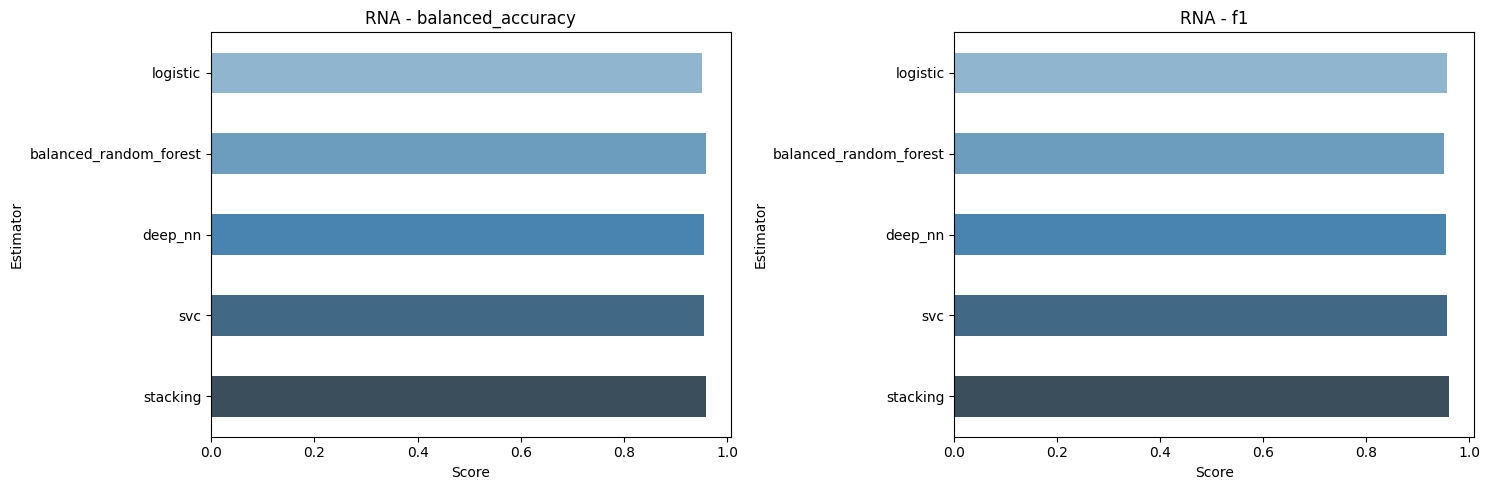

In [32]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

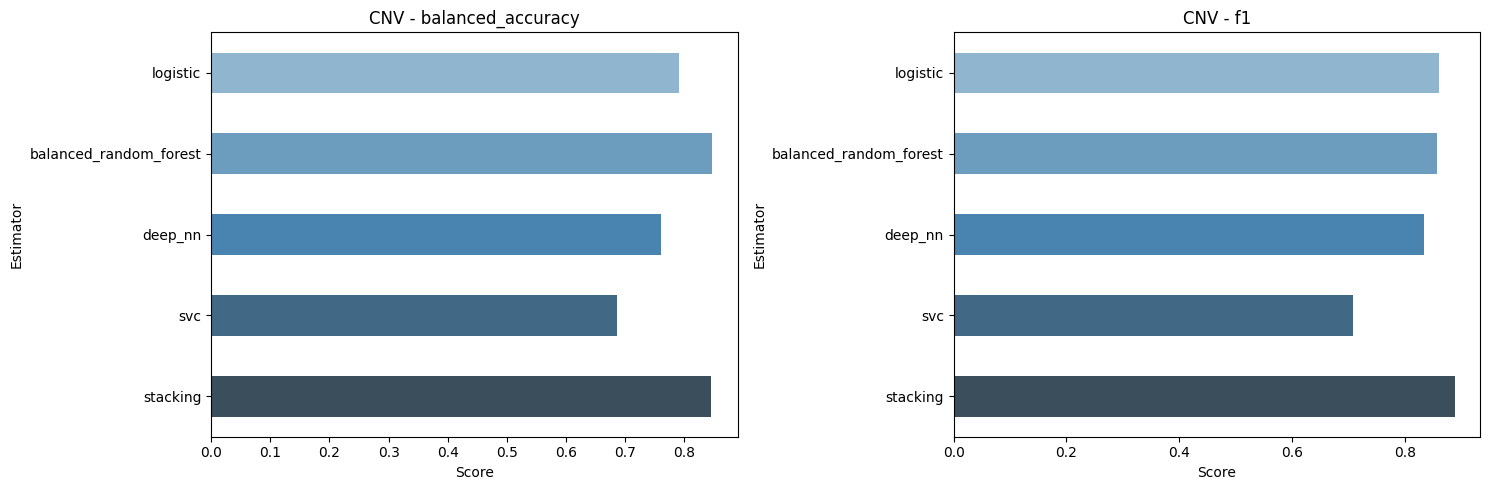

In [33]:
plot_bar_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

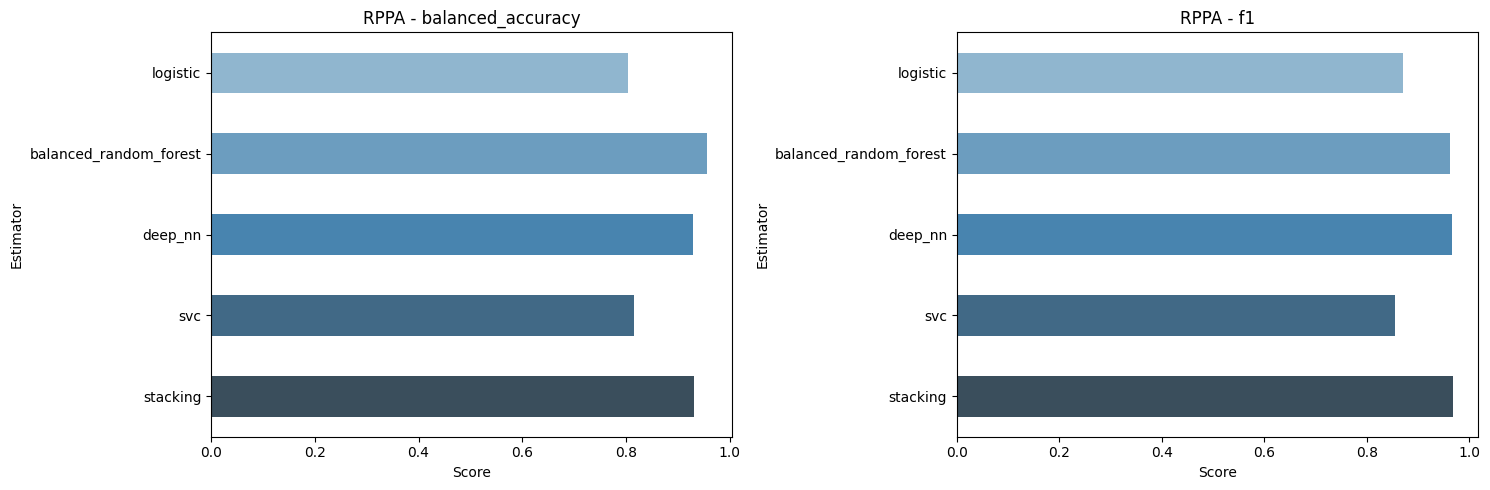

In [34]:
plot_bar_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


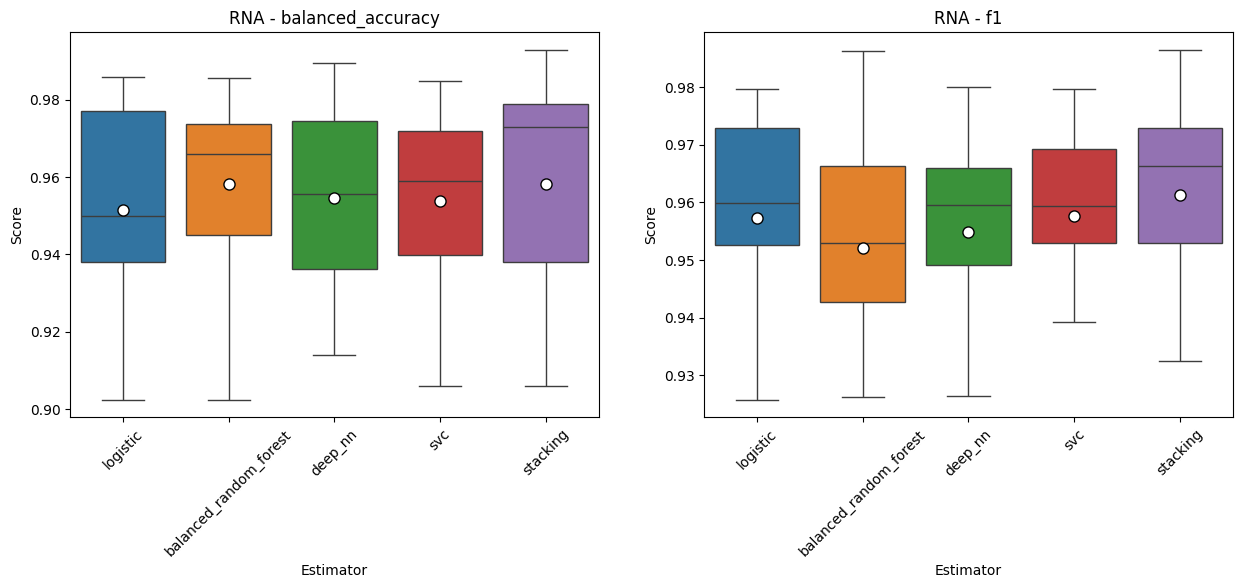

In [35]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


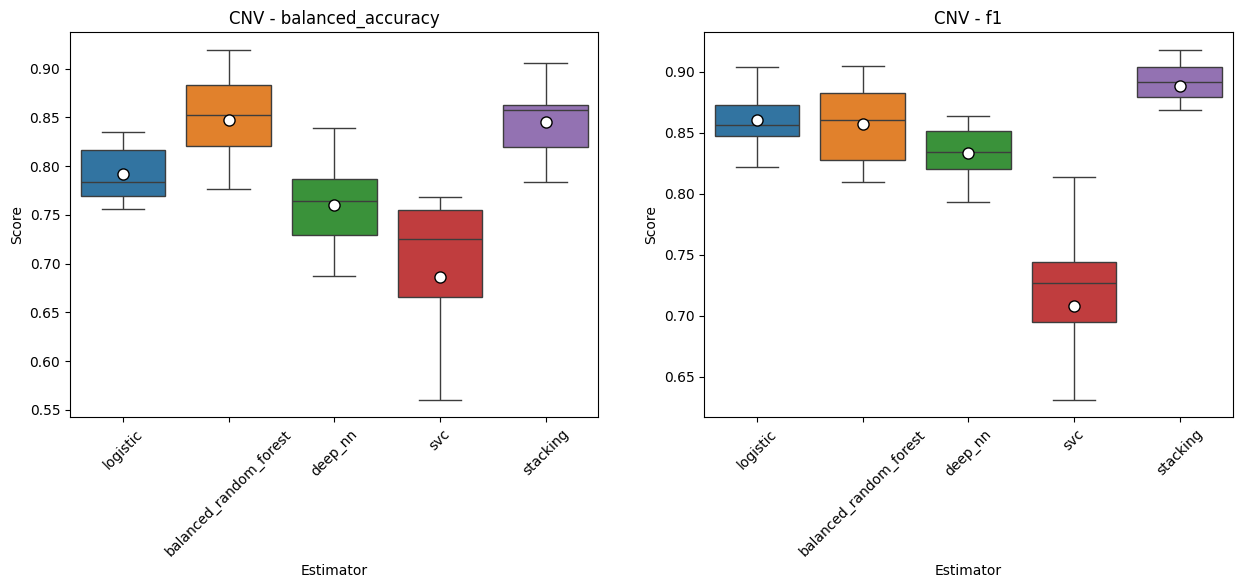

In [36]:
plot_box_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:178: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


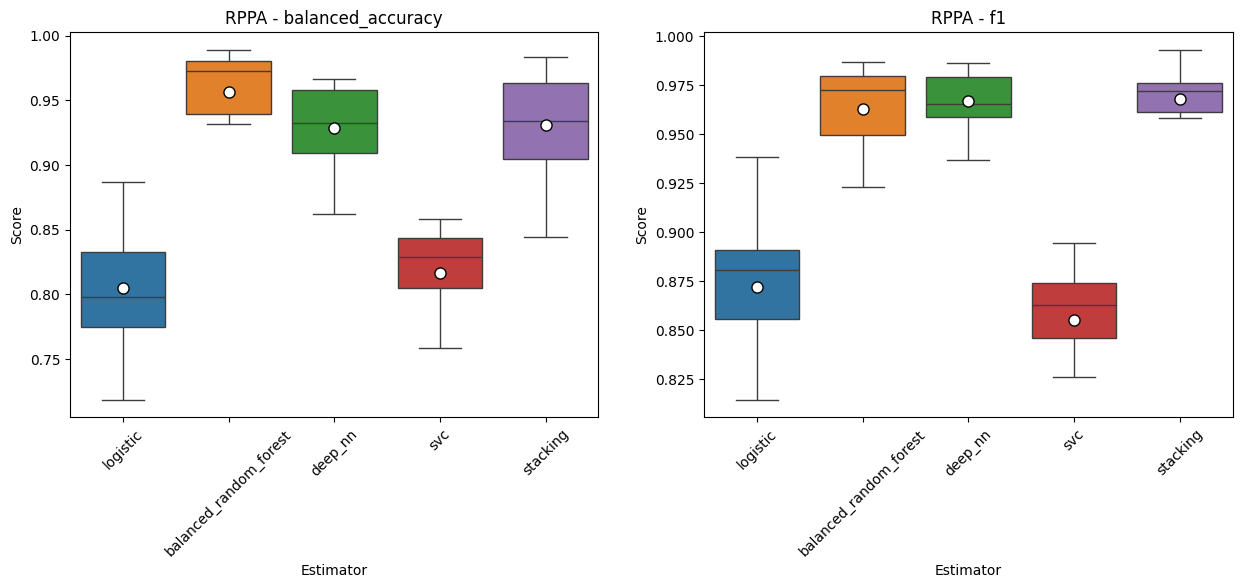

In [37]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

In [46]:
# Picking models we want to compare performances for
compare = [
    ('rna', 'stacking', 'svc'),
    ('cnv', 'stacking', 'logistic'),
    ('rppa', 'stacking', 'deep_nn')
]

In [47]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for modality, est1, est2 in compare:
        df = wilcoxen_test(est1, est2, all_scores[modality][est1]['test_' + metric], all_scores[modality][est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scip

In [48]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,stacking,svc,32.0,0.024835,True
0,stacking,logistic,115.0,0.000305,True
0,stacking,deep_nn,50.0,0.37643,False


,estimator_1,estimator_2,statistic,p,significant
0,stacking,svc,40.0,0.019076,True
0,stacking,logistic,116.0,0.000214,True
0,stacking,deep_nn,53.0,0.30009,False


## Multi Omics Integration Ensemble

### Ensemble Model as a Custom Classifier

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')

In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


In [ ]:
integration_metrics['rna + cnv + rppa']

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna + cnv + rppa,0.974 +/- 0.013,0.964 +/- 0.033,0.974 +/- 0.013,0.938 +/- 0.090,0.979 +/- 0.019,0.976 +/- 0.022


In [ ]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [ ]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'cnv']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.8min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096
rppa,0.973 +/- 0.012,0.953 +/- 0.023,0.973 +/- 0.012,0.922 +/- 0.049,0.991 +/- 0.011,0.947 +/- 0.028
rna + cnv + rppa,0.974 +/- 0.013,0.964 +/- 0.033,0.974 +/- 0.013,0.938 +/- 0.090,0.979 +/- 0.019,0.976 +/- 0.022
cnv + rppa,0.977 +/- 0.014,0.970 +/- 0.028,0.977 +/- 0.014,0.969 +/- 0.062,0.989 +/- 0.014,0.952 +/- 0.031
rna + rppa,0.978 +/- 0.016,0.965 +/- 0.031,0.978 +/- 0.016,0.938 +/- 0.090,0.987 +/- 0.021,0.971 +/- 0.010
rna + cnv,0.952 +/- 0.018,0.948 +/- 0.023,0.953 +/- 0.017,0.938 +/- 0.090,0.955 +/- 0.029,0.951 +/- 0.027


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_multi_omics_results_2.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_multi_omics_results_2.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

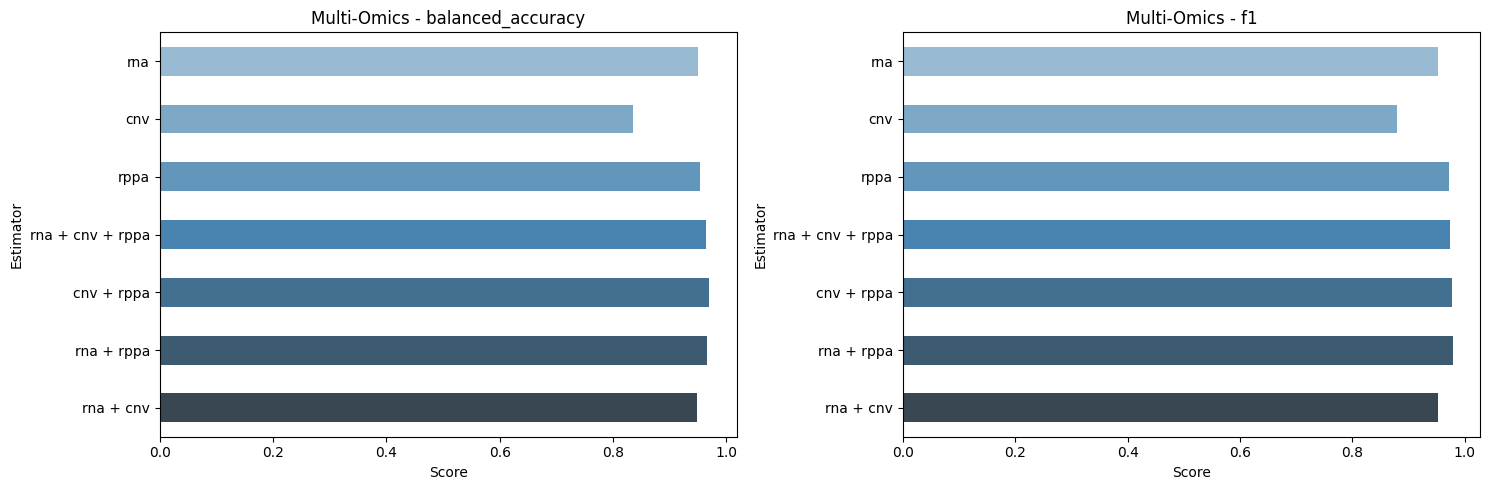

In [ ]:
plot_bar_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


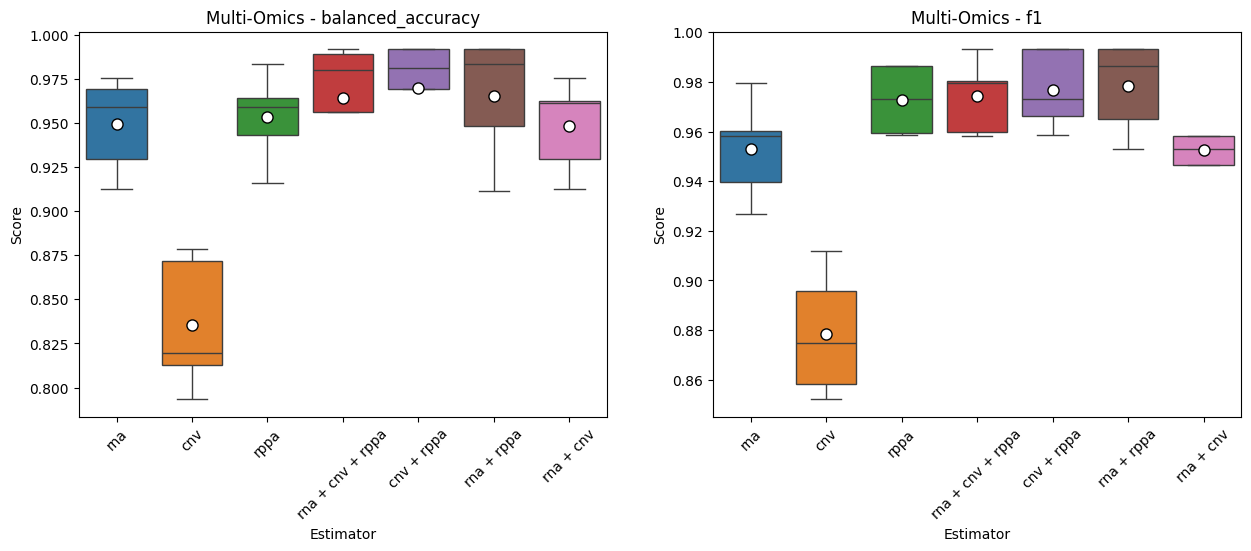

In [ ]:
plot_box_scores(names, all_integration_scores.values(), 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['rppa'], ensemble_metrics['rppa'] = get_cross_metrics(classifiers['rppa'], X['rppa'], y, name='rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)

In [ ]:
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)

In [ ]:
ensemble_results['cnv'], ensemble_metrics['cnv'] = get_cross_metrics(classifiers['cnv'], X['cnv'], y, name='cnv', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)

In [ ]:
ensemble_results['cnv + rppa'], ensemble_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})


In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

In [ ]:
ensemble_results['rna + cnv'], ensemble_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'cnv']}})

In [ ]:
ensemble_results['rna + cnv + rppa'], ensemble_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('cnv + rppa', 'rppa'),
    ('rna + rppa', 'rna'),
    ('rna + cnv + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results_2[est1]['test_' + metric], ensemble_results_2[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,cnv + rppa,rppa,66.0,0.001673,True
0,rna + rppa,rna,119.0,0.000061,True
0,rna + cnv + rppa,rna,108.0,0.002136,True


,estimator_1,estimator_2,statistic,p,significant
0,cnv + rppa,rppa,66.0,0.001673,True
0,rna + rppa,rna,120.0,0.000031,True
0,rna + cnv + rppa,rna,120.0,0.000031,True


In [ ]:
# Run this if continuing an already saved run:
with open("results/kipan/subtyping/kipan_5x3_results.json",'r+') as file:
    ensemble_results_2 = json.load(file)
    ensemble_metrics_2 = pd.DataFrame()

    for model in ensemble_results_2:
      metrics = {}

      for scorer in kipan_scoring:
        metrics[scorer] = []

      for scorer in kipan_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(ensemble_results_2[model]["test_%s" % scorer]), np.std(ensemble_results_2[model]["test_%s" % scorer]))
      )
      ensemble_metrics_2 = pd.concat([ensemble_metrics_2, pd.DataFrame(metrics, index=[model])])

In [ ]:
integration_results = {}
integration_results['rna'] = ensemble_results_2['rna']
integration_results['cnv'] = ensemble_results['cnv']
integration_results['rppa'] = ensemble_results_2['rppa']
integration_results['rna + cnv'] = ensemble_results['rna + cnv']
integration_results['rna + rppa'] = ensemble_results_2['rna + rppa']
integration_results['cnv + rppa'] = ensemble_results_2['cnv + rppa']
integration_results['rna + cnv + rppa'] = ensemble_results_2['rna + cnv + rppa']

In [ ]:
integration_metrics = pd.DataFrame()

for model in integration_results:
      metrics = {}

      for scorer in kipan_scoring:
        metrics[scorer] = []

      for scorer in kipan_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(integration_results[model]["test_%s" % scorer]), np.std(integration_results[model]["test_%s" % scorer]))
      )
      integration_metrics = pd.concat([integration_metrics, pd.DataFrame(metrics, index=[model])])

In [ ]:
integration_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.961 +/- 0.021,0.958 +/- 0.029,0.961 +/- 0.021,0.948 +/- 0.061,0.961 +/- 0.022,0.966 +/- 0.032
cnv,0.890 +/- 0.022,0.846 +/- 0.034,0.889 +/- 0.022,0.789 +/- 0.083,0.940 +/- 0.018,0.808 +/- 0.055
rppa,0.969 +/- 0.015,0.931 +/- 0.039,0.968 +/- 0.016,0.848 +/- 0.108,0.992 +/- 0.009,0.953 +/- 0.026
rna + cnv,0.957 +/- 0.022,0.949 +/- 0.033,0.958 +/- 0.022,0.926 +/- 0.072,0.961 +/- 0.022,0.960 +/- 0.032
rna + rppa,0.984 +/- 0.013,0.974 +/- 0.025,0.984 +/- 0.013,0.959 +/- 0.056,0.994 +/- 0.007,0.969 +/- 0.025
cnv + rppa,0.977 +/- 0.012,0.965 +/- 0.024,0.977 +/- 0.012,0.943 +/- 0.066,0.989 +/- 0.014,0.963 +/- 0.025
rna + cnv + rppa,0.977 +/- 0.017,0.969 +/- 0.027,0.977 +/- 0.017,0.953 +/- 0.055,0.984 +/- 0.016,0.968 +/- 0.032


/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


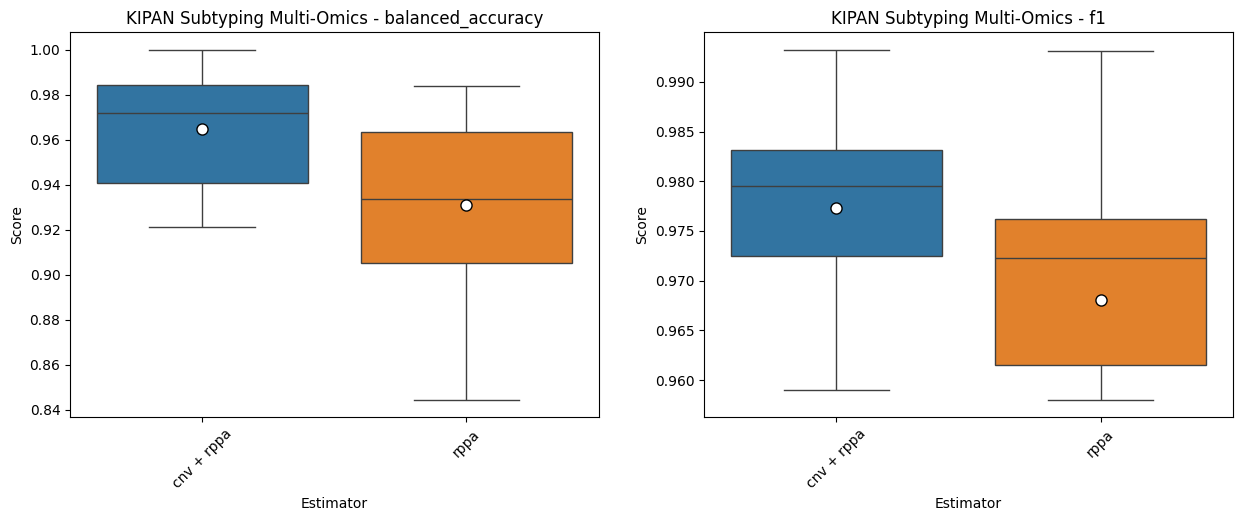

In [ ]:
plot_box_scores(['cnv + rppa', 'rppa'], [ensemble_results['cnv + rppa'], ensemble_results['rppa']], 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


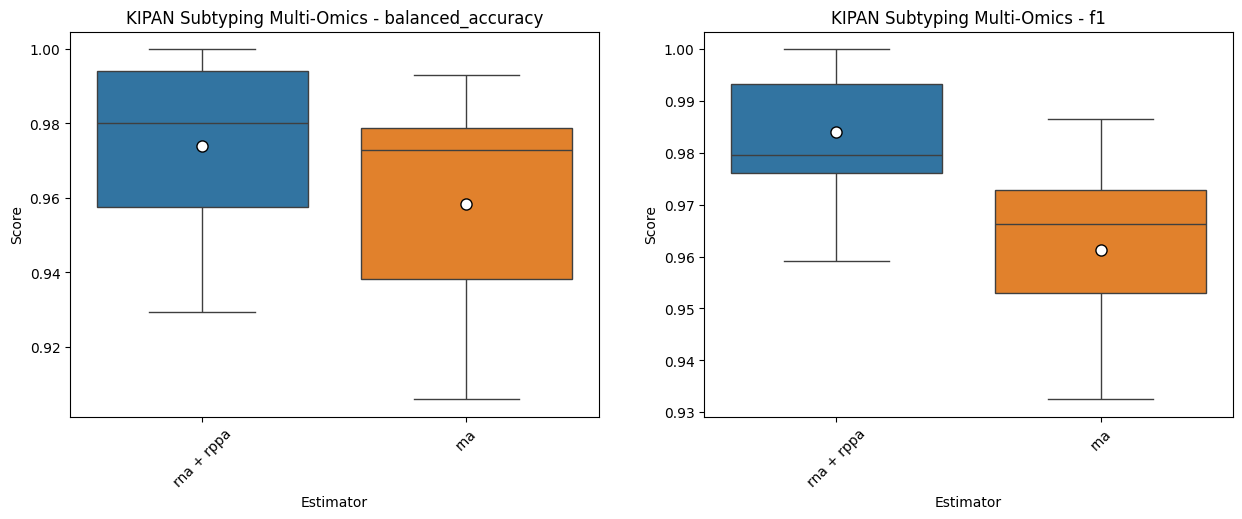

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


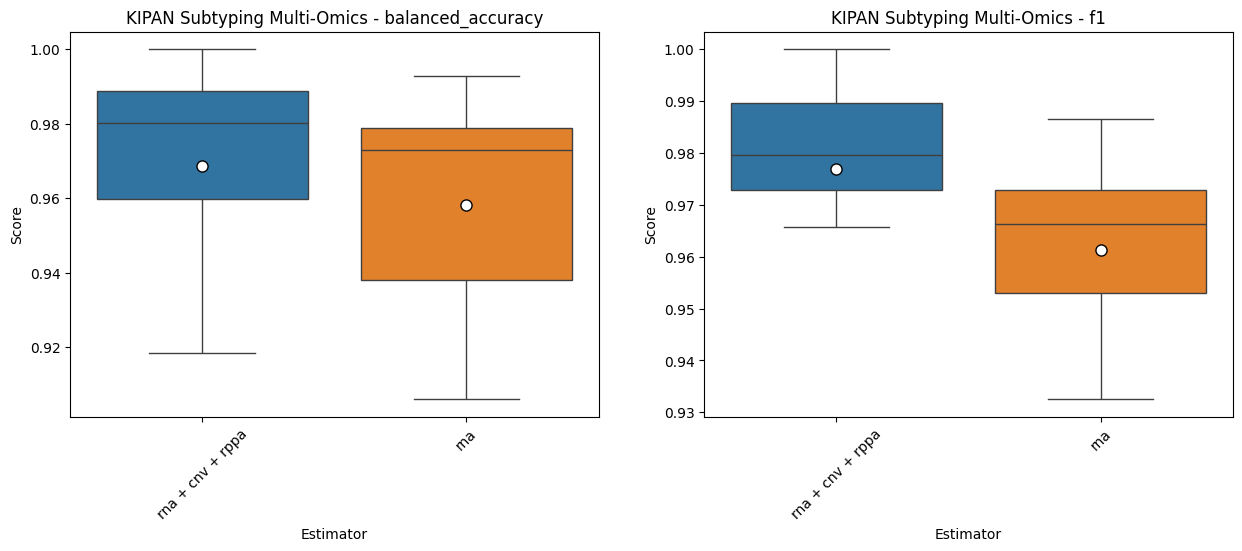

In [ ]:
plot_box_scores(['rna + cnv + rppa', 'rna'], [ensemble_results['rna + cnv + rppa'], ensemble_results['rna']], 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
names = ['rna', 'cnv', 'rppa', 'rna + cnv', 'rna + rppa', 'cnv + rppa', 'rna + cnv + rppa']

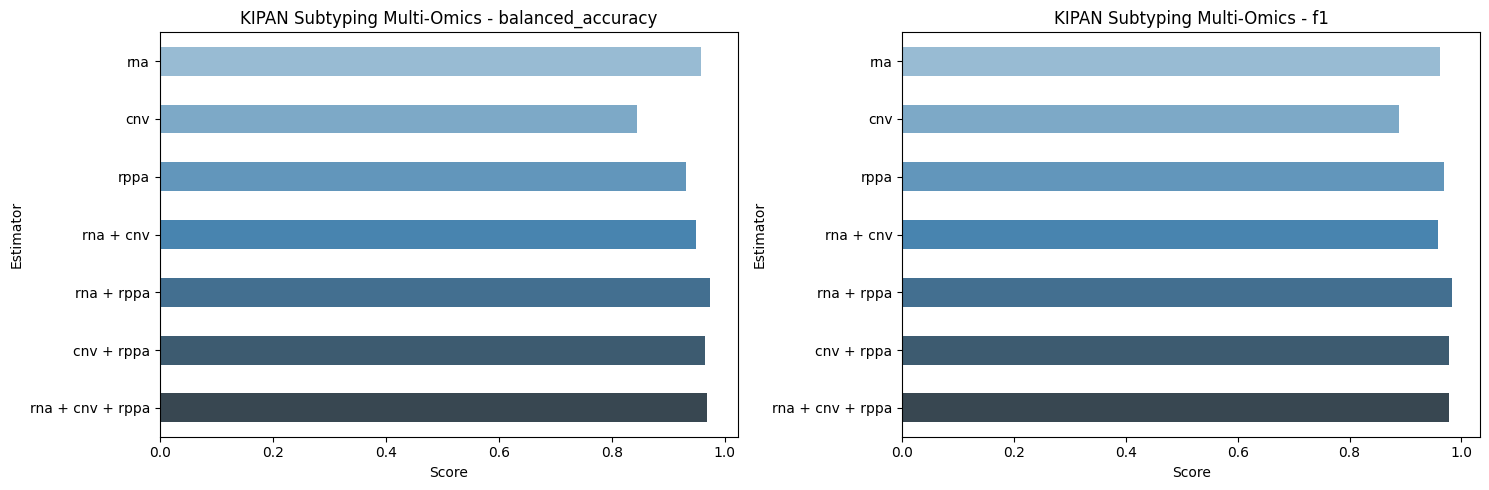

In [ ]:
plot_bar_scores(names, integration_results.values(), 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


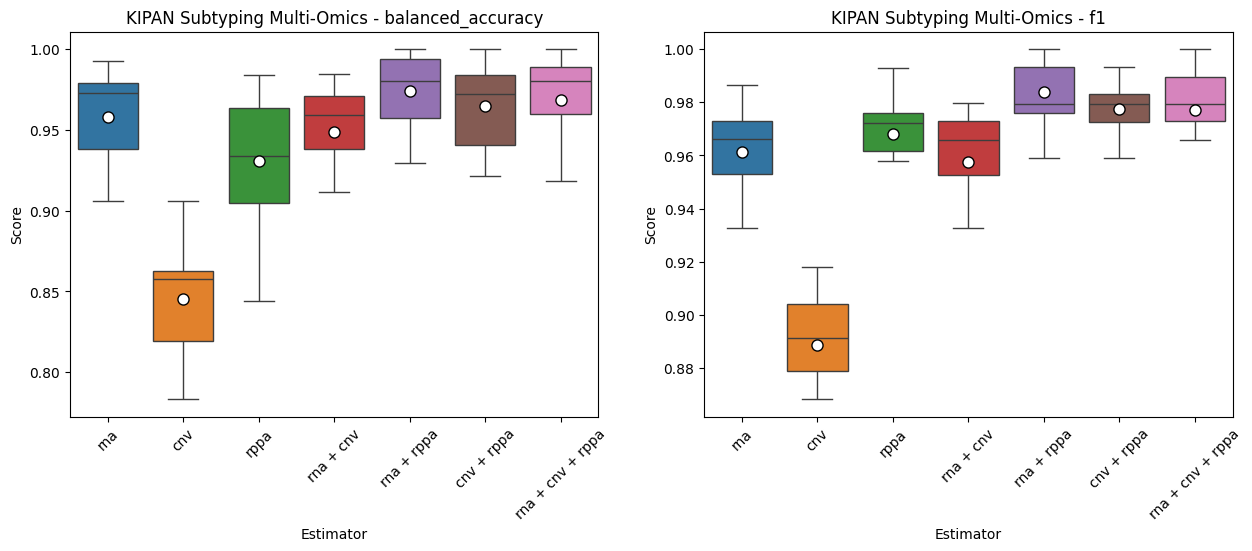

In [ ]:
plot_box_scores(names, integration_results.values(), 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [53]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_5x3_results_final.json", "w") as outfile:
    json.dump(integration_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X_merged['rna + cnv + rppa'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
meta_ensembles['rna + cnv + rppa'].fit(X_train, y_train, column_names)

MultiOmicsIntegrationClassifier(cv=3,
                                estimator_dict={'cnv': ModalityPipeline(cv=3,
                                                                        estimator_list=[('logistic',
                                                                                         Pipeline(steps=[('standardscaler',
                                                                                                          StandardScaler()),
                                                                                                         ('logisticregression',
                                                                                                          LogisticRegression(max_iter=1000,
                                                                                                                             n_jobs=-1,
                                                                                                                             random_state=0))])),
                                                                                        ('balanced_random_forest',
                                                                                         BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                        random_state=0,
                                                                                                                        replacement=True,
                                                                                                                        sampl...
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         sampling_strategy='all')),
                                                                                         ('deep_nn',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('mlpclassifier',
                                                                                                           MLPClassifier(random_state=0))])),
                                                                                         ('svc',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('svc',
                                                                                                           SVC(kernel='linear',
                                                                                                               max_iter=1000,
                                                                                                               random_state=0))]))])})

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_scoring.items():
  baseline_scores[name] = get_scorer(scorer)(meta_ensembles['rna + cnv + rppa'], X_test, y_test)

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
,0.978261,0.966933,0.978261,0.9375,0.982906,0.980392


In [ ]:
result = permutation_importance(meta_ensembles['rna + cnv + rppa'], X_test, y_test, n_repeats=10, random_state=0, scoring=kipan_scoring, n_jobs=-1)

In [ ]:
sorted_importances_idx = result['balanced_accuracy'].importances_mean.argsort()
importances = pd.DataFrame(
    result['balanced_accuracy'].importances[sorted_importances_idx].T,
    columns=X_merged['rna + cnv + rppa'].columns[sorted_importances_idx],
)

importances.head()

,KIT_rna,ATP6V0D2_rna,TMPRSS2_rna,RPTOR|Raptor_RPPA,PLA2G4F_rna,RHCG_rna,FABP7_rna,NTN1_rna,MYO7B_rna,NFKB1|NF-kB-p65_pS536_RPPA,...,GATA3|GATA3_RPPA,EIF4EBP1|4E-BP1_RPPA,TGM2|Transglutaminase_RPPA,RAB25|Rab25_RPPA,DVL3|Dvl3_RPPA,ERBB2|HER2_RPPA,CCNB1|Cyclin_B1_RPPA,ERBB2|HER2_pY1248_RPPA,PRKAA1|AMPK_pT172_RPPA,CDH2|N-Cadherin_RPPA
0,-0.002849,-0.002849,-0.002849,0.000000,-0.002849,-0.002849,-0.002849,-0.002849,-0.002849,0.000000,...,0.012234,0.000000,0.017984,0.020833,0.000000,0.002849,0.000000,0.000000,0.020833,0.020833
1,-0.002849,-0.002849,-0.002849,0.002849,0.000000,0.000000,-0.002849,0.000000,-0.002849,0.000000,...,0.002849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002849,0.020833
2,-0.002849,-0.002849,-0.002849,-0.006536,-0.002849,-0.002849,-0.002849,0.000000,-0.002849,-0.002849,...,0.006536,0.000000,0.020833,0.041667,0.000000,0.002849,0.000000,0.000000,0.000000,0.020833
3,-0.002849,-0.002849,-0.002849,-0.006536,-0.002849,-0.002849,0.000000,-0.002849,-0.002849,0.000000,...,0.000000,-0.002849,-0.002849,0.000000,0.020833,0.000000,0.000000,0.020833,0.000000,0.002849
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020833,0.000000,0.000000,0.020833,0.020833,0.020833,0.020833,0.000000,0.020833


In [ ]:
importances.iloc[:, -20:].columns

Index(['YWHAZ|14-3-3_zeta_RPPA', 'AR|AR_RPPA', 'MSH2|MSH2_RPPA',
       'CHEK2|Chk2_RPPA', 'BAK1|Bak_RPPA', 'ACVRL1|ACVRL1_RPPA',
       'EGFR|EGFR_RPPA', 'MAP2K1|MEK1_pS217_S221_RPPA', 'PIK3R1|PI3K-p85_RPPA',
       'AKT1S1|PRAS40_pT246_RPPA', 'GATA3|GATA3_RPPA', 'EIF4EBP1|4E-BP1_RPPA',
       'TGM2|Transglutaminase_RPPA', 'RAB25|Rab25_RPPA', 'DVL3|Dvl3_RPPA',
       'ERBB2|HER2_RPPA', 'CCNB1|Cyclin_B1_RPPA', 'ERBB2|HER2_pY1248_RPPA',
       'PRKAA1|AMPK_pT172_RPPA', 'CDH2|N-Cadherin_RPPA'],
      dtype='object')

Text(0, 0.5, 'Genes')

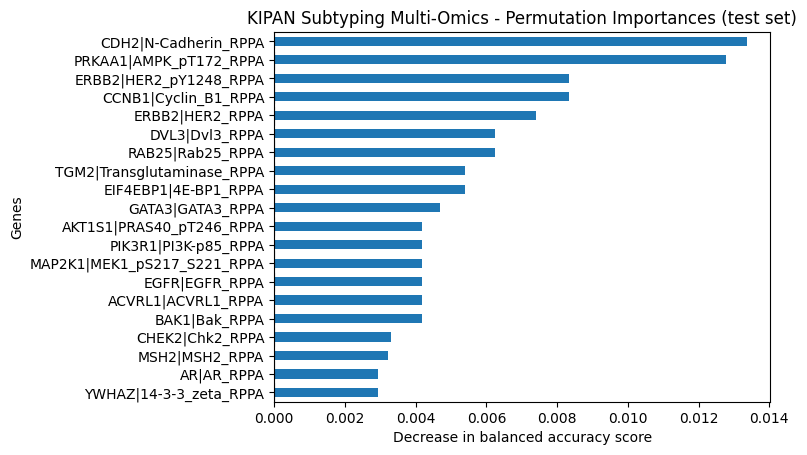

In [ ]:
# Printing top 20 important features
ax = importances.mean()[-20:].plot(kind='barh')
ax.set_title("KIPAN Subtyping Multi-Omics - Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.set_ylabel('Genes')

Text(0, 0.5, 'Genes')

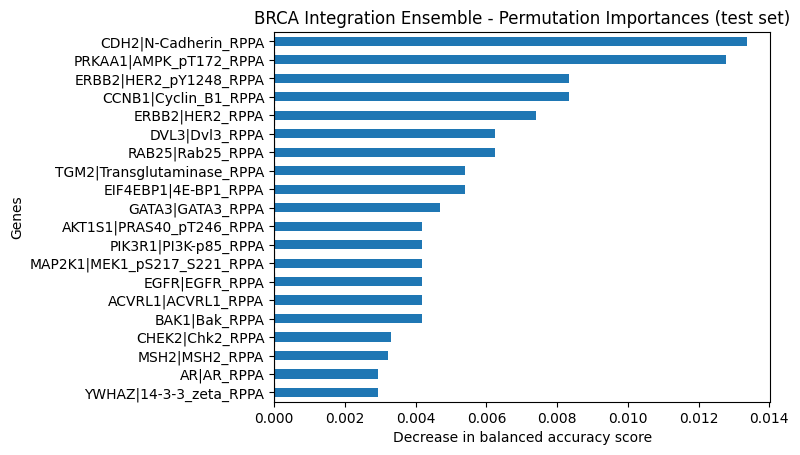

In [ ]:
# Printing top 20 important features
ax = importances.mean()[-20:].plot(kind='barh')
ax.set_title("KIPAN Integration Ensemble - Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.set_ylabel('Genes')

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_merged['rna + cnv + rppa'].columns[i])
        print(f"{X_merged['rna + cnv + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.4f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.4f}")

CDH2|N-Cadherin_RPPA  0.0134 +/- 0.0098
PRKAA1|AMPK_pT172_RPPA  0.0128 +/- 0.0099
ERBB2|HER2_pY1248_RPPA  0.0083 +/- 0.0102
CCNB1|Cyclin_B1_RPPA  0.0083 +/- 0.0102
ERBB2|HER2_RPPA  0.0074 +/- 0.0095
DVL3|Dvl3_RPPA  0.0063 +/- 0.0095
RAB25|Rab25_RPPA  0.0063 +/- 0.0133
TGM2|Transglutaminase_RPPA  0.0054 +/- 0.0090
EIF4EBP1|4E-BP1_RPPA  0.0054 +/- 0.0089
GATA3|GATA3_RPPA  0.0047 +/- 0.0040
AKT1S1|PRAS40_pT246_RPPA  0.0042 +/- 0.0083
PIK3R1|PI3K-p85_RPPA  0.0042 +/- 0.0083
MAP2K1|MEK1_pS217_S221_RPPA  0.0042 +/- 0.0083
EGFR|EGFR_RPPA  0.0042 +/- 0.0083
ACVRL1|ACVRL1_RPPA  0.0042 +/- 0.0083
BAK1|Bak_RPPA  0.0042 +/- 0.0083
CHEK2|Chk2_RPPA  0.0033 +/- 0.0071
MSH2|MSH2_RPPA  0.0032 +/- 0.0069
AR|AR_RPPA  0.0029 +/- 0.0070
YWHAZ|14-3-3_zeta_RPPA  0.0029 +/- 0.0024
EGFR|EGFR_pY1068_RPPA  0.0026 +/- 0.0015
IRS1|IRS1_RPPA  0.0024 +/- 0.0062
EIF4G1|eIF4G_RPPA  0.0024 +/- 0.0062
YBX1|YB-1_pS102_RPPA  0.0023 +/- 0.0011
ERCC1|ERCC1_RPPA  0.0023 +/- 0.0017
MYH11|MYH11_RPPA  0.0022 +/- 0.0032
PEA15|PE

In [ ]:
top_genes_modality = {}

for modality in datasets:
  top_genes_modality[modality] = []

for gene in top_genes:
  for modality in datasets:
    if ("_" + modality) in gene.lower():
      #top_genes_modality[modality].append(gene.removesuffix('_'+modality))
      top_genes_modality[modality].append(gene)
      break

In [ ]:
# Printing to copy-paste into top-gene for enrichment analysis
for modality in top_genes_modality:
  print(f"{modality}: " + ','.join(top_genes_modality[modality]))
  print("")

rna: 

cnv: LARGE_cnv,SEMA3E_cnv,ZNF716_cnv,MIR3147_cnv,ZNF479_cnv,RN7SL816P_cnv,SGCG_cnv,CDH18_cnv,CLIC6_cnv,CADM2_cnv,AKAP4_cnv,RN7SL740P_cnv,LINC00310_cnv,BIVM_cnv,RCAN1_cnv,TPGS2_cnv,OXR1_cnv,LINC00283_cnv,TEX30_cnv,KDELC1_cnv,ABRA_cnv,CCNB3_cnv,GPR56_cnv,MIR5688_cnv,LINC00649_cnv,FAR2_cnv,snoU13|ENSG00000238865.1_cnv,ATP5O_cnv,PCLO_cnv,RN7SL109P_cnv,MIS18A_cnv,DGKK_cnv,ANKRD11_cnv,RN7SKP284_cnv,MIR3920_cnv,C8orf86_cnv,RHOV_cnv,ZC3H12B_cnv,SPINT1_cnv,CELF4_cnv,LAS1L_cnv,OPHN1_cnv,SLC14A2_cnv,VGLL3_cnv,MYO5B_cnv,MIR4795_cnv,TMCC1_cnv,TRPC6_cnv,CDC73_cnv,PLXNA2_cnv,CAMK1D_cnv,PGR_cnv,SLC30A10_cnv,SNTG1_cnv,DSG3_cnv,CCDC120_cnv,PAK7_cnv,SLC39A11_cnv

rppa: CDH2|N-Cadherin_RPPA,PRKAA1|AMPK_pT172_RPPA,ERBB2|HER2_pY1248_RPPA,CCNB1|Cyclin_B1_RPPA,ERBB2|HER2_RPPA,DVL3|Dvl3_RPPA,RAB25|Rab25_RPPA,TGM2|Transglutaminase_RPPA,EIF4EBP1|4E-BP1_RPPA,GATA3|GATA3_RPPA,AKT1S1|PRAS40_pT246_RPPA,PIK3R1|PI3K-p85_RPPA,MAP2K1|MEK1_pS217_S221_RPPA,EGFR|EGFR_RPPA,ACVRL1|ACVRL1_RPPA,BAK1|Bak_RPPA,CHEK2|Chk2_

In [ ]:
# Convert and write csv object to file
with open("results/kipan/subtyping/permutation_results.csv", "w") as outfile:
    importances.to_csv(outfile)

In [ ]:
with open("results/kipan/subtyping/marker_genes.json", "w") as outfile:
    json.dump(top_genes_modality, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)